In [47]:
import os
import copy
from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm
from sklearn.neighbors import NearestNeighbors

# import node2vec

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from utils import *
from dataset import *
from train import train, test, device

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
G = nx.readwrite.read_gpickle('data/network.gpickle')

In [49]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_graph = from_networkx(G)
pyg_graph.to(device)

Data(x=[60789, 128], edge_index=[2, 151294], lng=[60789], lat=[60789], id=[60789], dist=[151294])

$$T(a) = \sum_{b \neq a,\space b\subset Train } T(b)w(a, b), \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$$ w(a,b)= k \frac{u(a,b)}{\sum_{b \neq a} u(a, b)}  + (1-k) \frac{g(a,b)}{\sum_{b \neq a} g(a,b)};$$

$u(a, b) = exp(-\lambda_1 d(a, b));$

$g(a, b) = exp(-\lambda_2 similarity(x_a, x_b))$, where similarity is cosine distance (can be dot product by the way);

$x_a$ is an embedding for a node **a**;

So for this model $k$, $\lambda_1$, $\lambda_2$ are optimized.

In [50]:
def weight_fn(dists, lamb):
    return torch.exp(-lamb * dists)


class Estimator(nn.Module):
    def __init__(self, pyg_graph: pyg.data.Data, observations: Tuple[List, List]) -> None:
        super().__init__()

        self.g = pyg_graph
        self.obs_nodes = observations[0]
        self.obs_targets = observations[1]

        self.NEIGHBORS_NUM = 15
        
        # dicts for fast indexing
        self.node_to_gidx = np.vectorize(dict(zip(self.g.id.detach().cpu().numpy(), range(len(self.g.id)))).get)
        
        self.neighbors = NearestNeighbors(n_neighbors=self.NEIGHBORS_NUM, metric='haversine')
        obs_nodes_indices = self.node_to_gidx(self.obs_nodes)
        self.neighbors.fit(torch.vstack([self.g.lat[obs_nodes_indices], self.g.lng[obs_nodes_indices]]).T.detach().cpu())

        self.k = nn.Parameter(torch.rand(1))
        # self.k = torch.tensor([1.0]).to(device)
        self.lambda_1 = nn.Parameter(torch.rand(1))
        self.lambda_2 = nn.Parameter(torch.rand(1))

    def forward(self, X):
        # getting nearest observed nodes
        X_indices = self.node_to_gidx(X.detach().cpu())
        dists, indices = self.neighbors.kneighbors(torch.vstack([self.g.lat[X_indices], self.g.lng[X_indices]]).T.detach().cpu())
        # converting dists to meters
        dists = dists * 6371 * 1000

        # skipping loc by itself
        if self.training:
            dists, indices = dists[:, 1:], indices[:, 1:]
        
        observations = self.obs_targets[indices.reshape(-1)].reshape(*indices.shape)

        dists, observations = torch.as_tensor(dists).to(device), torch.as_tensor(observations).to(device)

        # finding corresponding node embedding of neighbors
        neighbors_indices = self.node_to_gidx(self.obs_nodes[indices.reshape(-1)])
        neighbors_embeds = self.g.x[neighbors_indices].reshape(*indices.shape, -1)

        # computing similarities between node ans its neighbors
        X_embeds = self.g.x[X_indices]
        similarities = nn.functional.cosine_similarity(X_embeds[:, None], neighbors_embeds, dim=2)

        dist_weights = weight_fn(dists, self.lambda_1)
        simi_weights = weight_fn(similarities, self.lambda_2)

        # sum normalizization
        dist_weights = nn.functional.normalize(dist_weights, p=1)
        simi_weights = nn.functional.normalize(simi_weights, p=1)

        att_weights = self.k * dist_weights + (1 - self.k) * simi_weights

        # interpolation
        result = torch.sum(att_weights.mul(observations), dim=-1)

        return result

In [51]:
results = dict()

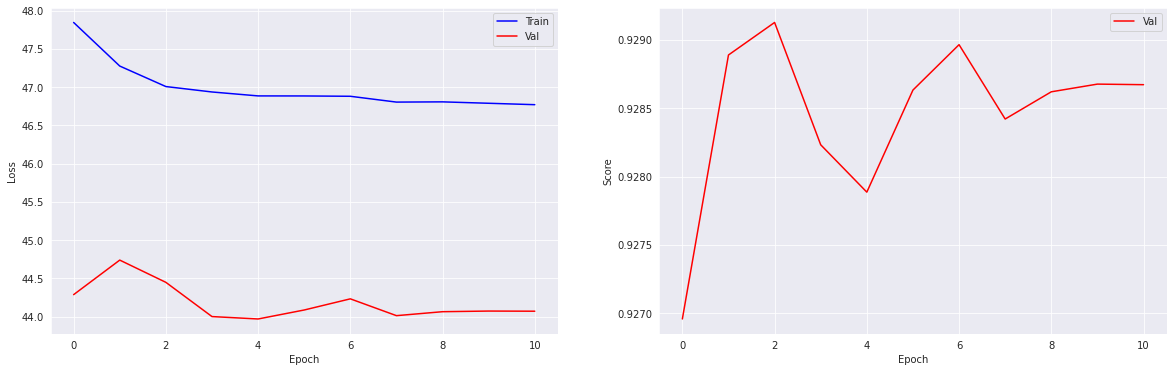

Day 1, Test loss: 43.2378, test score: 0.9257


In [54]:
loss_fn = nn.HuberLoss(delta=20).to(device)

for day in tqdm(range(1, 20)):
    path = f'datasets/day_{day}.dat'

    try:
        ds = torch.load(path)
    except:
        continue

    train_loader, val_loader, test_loader = make_data_loaders_from_dataset(ds, train_batch_size=64)
    train_batches = [batch for batch in train_loader]
    train_nodes = torch.cat([batch[0] for batch in train_batches])
    train_targets = torch.cat([batch[1] for batch in train_batches])

    model = Estimator(pyg_graph, (train_nodes, train_targets)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.7)

    best_model = train(model, train_loader, val_loader, loss_fn, optimizer, scheduler, plotting=True)
    test_loss, test_score = test(best_model, test_loader, loss_fn)

    # for name, param in best_model.named_parameters():
        # print(name, param)

    results[f'day_{day}'] = test_score 
    print(f'Day {day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [31]:
import json

with open('results/gnn0.json', mode='w') as f:
    json.dump(results, f, indent=4)